<a href="https://colab.research.google.com/github/whitehatjr1001/Deeplearning/blob/main/AnomolyDetectionVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

In [3]:
# this pre-processing code of the KDD dataset is adapter from https://github.com/lironber/GOAD/blob/master/data_loader.py

df_colnames = pd.read_csv(urls[1], skiprows=1, sep=':', names=['f_names', 'f_types'])
df_colnames.loc[df_colnames.shape[0]] = ['status', ' symbolic.']

df = pd.read_csv(urls[0], header=None, names=df_colnames['f_names'].values)
df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')]
df_continuous = df_colnames[df_colnames['f_types'].str.contains('continuous.')]
samples = pd.get_dummies(df.iloc[:, :-1], columns=df_symbolic['f_names'][:-1])

labels = np.where(df['status'] == 'normal.', 1, 0)

In [4]:
scalar = MinMaxScaler()
df = scalar.fit_transform(samples)

In [5]:
norm_samp = df[labels==1 ]
attk_samp = df[labels==0 ]
norm_labels =labels[labels == 1]
attk_labeles = labels[labels==0]

In [8]:
attk_samp.shape 

(396743, 121)

In [12]:
#partition into training and testing 
len_norm= len(norm_samp)
len_normtrain = int(0.8*len_norm)
X_train = norm_samp[1:len_norm]

X_testnorm = norm_samp[len_norm:]
len_atk=len(attk_samp)
X_testatk= attk_samp[:len_atk]

x_test=np.concatenate([X_train,X_testatk])
y_test = np.ones(len(x_test))
y_test[:len(X_testnorm)]=0

In [14]:
x_test.shape

(494020, 121)

In [17]:
y_test.shape

(494020,)

In [18]:
#reparmetrization trick
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [20]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [22]:
#encoder model
inputs = Input(shape=input_shape,name = 'encoder_inp')
x= Dense(intermediate_dim,activation = 'relu')(inputs)
z_mean = Dense(latent_dim,name = 'z_mean')(x)
z_log_var = Dense(latent_dim,name = 'z_log_var')(x)
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inp (InputLayer)       [(None, 121)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 60)           7320        ['encoder_inp[0][0]']            
                                                                                                  
 z_mean (Dense)                 (None, 40)           2440        ['dense_1[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 40)           2440        ['dense_1[0][0]']                
                                                                                            

In [23]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 40)]              0         
                                                                 
 dense_2 (Dense)             (None, 60)                2460      
                                                                 
 dense_3 (Dense)             (None, 121)               7381      
                                                                 
Total params: 9,841
Trainable params: 9,841
Non-trainable params: 0
_________________________________________________________________


In [24]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [27]:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [35]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,clipvalue=0.5)
vae_model.compile(optimizer =opt ,loss = vae_loss)
vae_model.summary()


Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inp (InputLayer)    [(None, 121)]             0         
                                                                 
 encoder (Functional)        (None, 40)                12200     
                                                                 
 decoder (Functional)        (None, 121)               9841      
                                                                 
Total params: 22,041
Trainable params: 22,041
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras.callbacks import ModelCheckpoint 
checkpoint =ModelCheckpoint('best_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')

In [37]:
hist = vae_model.fit(X_train,X_train,shuffle=True,epochs=50,batch_size=256)

Train on 97277 samples
Epoch 1/50
97277/97277 [==============================] - 2s 20us/sample - loss: 10.7334
Epoch 2/50
97277/97277 [==============================] - 2s 20us/sample - loss: 10.6016
Epoch 3/50
97277/97277 [==============================] - 2s 20us/sample - loss: 10.5881
Epoch 4/50
97277/97277 [==============================] - 2s 20us/sample - loss: 10.4799
Epoch 5/50
97277/97277 [==============================] - 2s 20us/sample - loss: 10.4465
Epoch 6/50
97277/97277 [==============================] - 3s 35us/sample - loss: 10.4895
Epoch 7/50
97277/97277 [==============================] - 2s 19us/sample - loss: 10.4457
Epoch 8/50
97277/97277 [==============================] - 2s 20us/sample - loss: 10.3969
Epoch 9/50
97277/97277 [==============================] - 2s 21us/sample - loss: 10.3694
Epoch 10/50
97277/97277 [==============================] - 2s 20us/sample - loss: 10.4783
Epoch 11/50
97277/97277 [==============================] - 2s 20us/sample - loss: 10.2

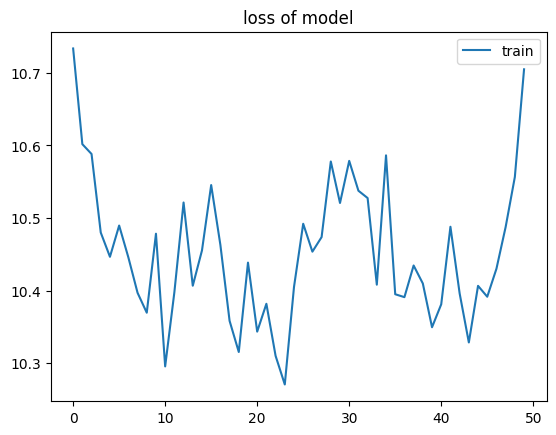

In [38]:
plt.plot(hist.history['loss'])
plt.title('loss of model')
plt.ylabel=['loss']
plt.xlabel=['epoch']
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [39]:
X_train_pred = vae_model.predict(X_train)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [41]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [42]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.001603895840715738
median error 0.0012049815962926432
99Q: 0.007312077474303795
setting threshold on 0.007312077474303795 


In [44]:
X_pred = vae_model.predict(x_test)
mae_vector = get_error_term(X_pred, x_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.7984474312780859

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.80      0.89    494020

    accuracy                           0.80    494020
   macro avg       0.50      0.40      0.44    494020
weighted avg       1.00      0.80      0.89    494020



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
X_encoded = encoder.predict(x_test)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

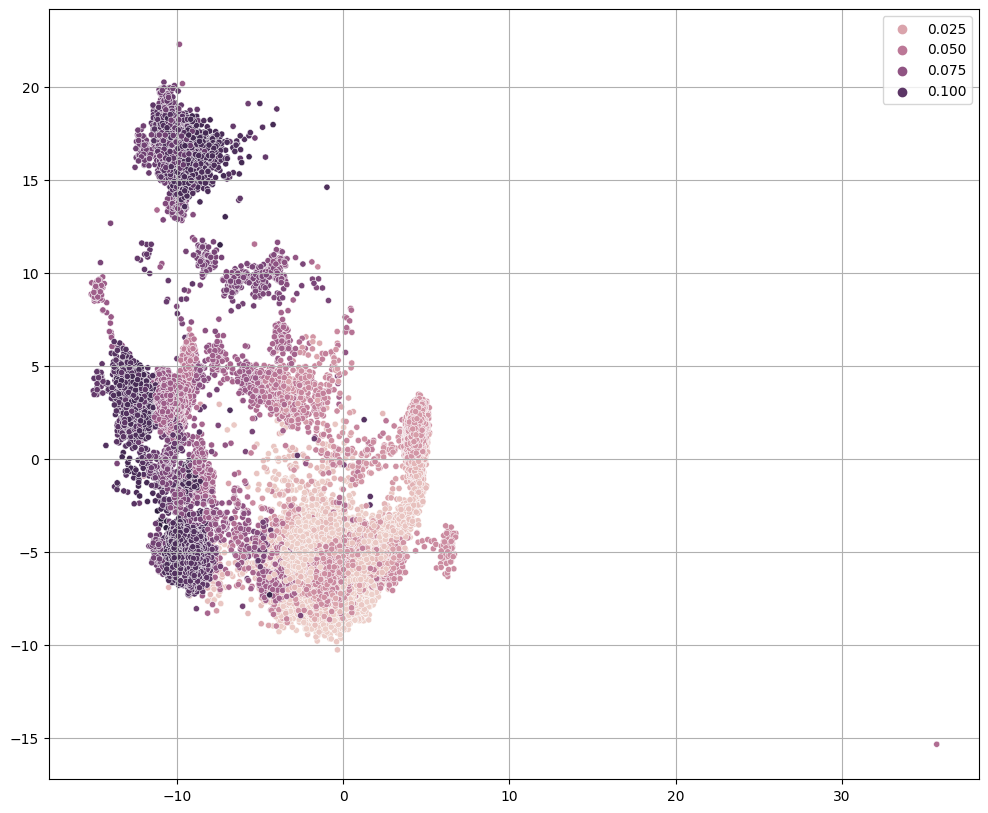

In [49]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

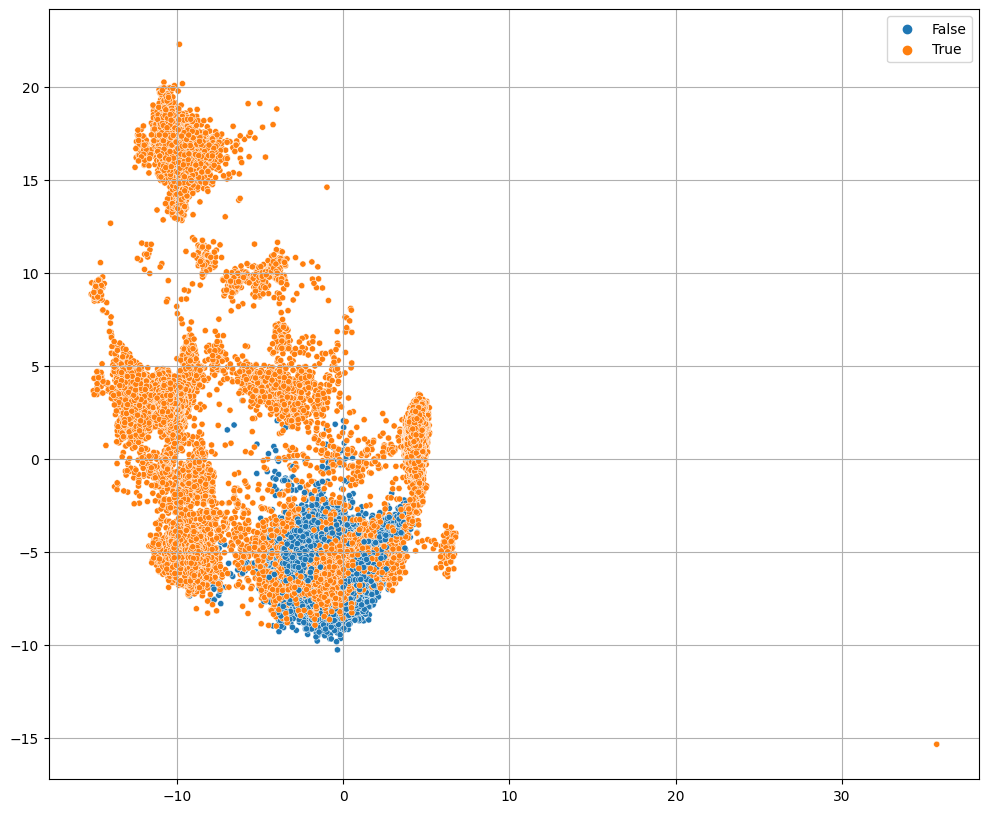

In [50]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

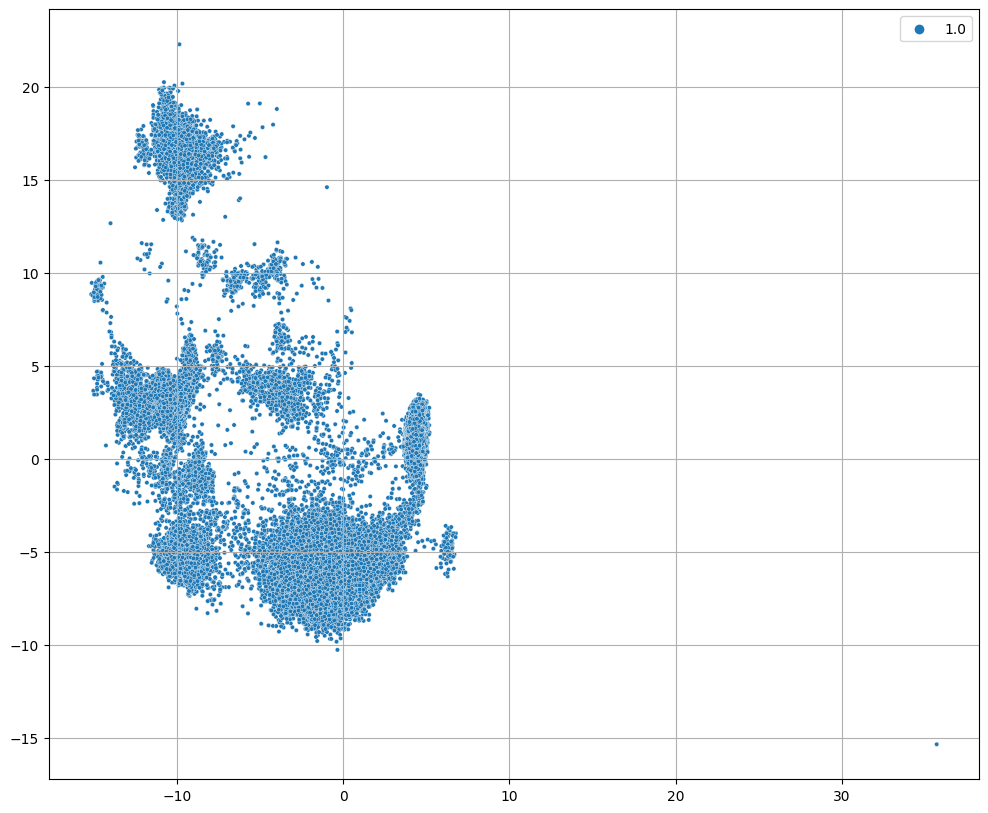

In [51]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()